In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import sys
from PIL import Image

In [2]:
df = pd.read_csv('data/train.csv')

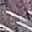

In [3]:
im = Image.open("data/train/000c8a36845c0208e833c79c1bffedd1.jpg")
im

In [4]:
shape = (len(df),) + im.size + (3,)

In [5]:
len(df)

17500

In [6]:
train_images = np.zeros(shape=shape, dtype=np.float16)
for i, file in enumerate(df['id']):
    train_images[i] = Image.open('data/train/' + str(file))

In [7]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, Dense, MaxPool2D, Flatten
from tensorflow.python.keras.layers import BatchNormalization, Activation, Dropout
from tensorflow.python.keras.optimizers import Adam

kernel_size=(3,3)
pool_size=(2,2)
first_filter=32
second_filter=64
third_filter=128

dropout_conv=0.3
dropout_dense=0.3

model = Sequential()
model.add(Conv2D(first_filter, kernel_size, padding='same', activation='relu', input_shape= (32,32,3)))
model.add(Conv2D(first_filter, kernel_size, padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filter, kernel_size, padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(second_filter, kernel_size, padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filter, kernel_size, padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filter, kernel_size, padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9216      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18432     
__________

In [10]:
df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [12]:
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

model.fit(x=train_images,
          y=df['has_cactus'],
          batch_size=128,
          epochs=50,
          validation_split=0.2,
          callbacks=[reducel, earlystopper])

Train on 14000 samples, validate on 3500 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
14000/14000 [==============================] - 10s 713us/sample - loss: 0.2329 - acc: 0.9201 - val_loss: 1.9383 - val_acc: 0.7443
Epoch 2/50
14000/14000 [==============================] - 6s 408us/sample - loss: 0.0961 - acc: 0.9614 - val_loss: 1.4925 - val_acc: 0.7491
Epoch 3/50
13952/14000 [============================>.] - ETA: 0s - loss: 0.0922 - acc: 0.9629
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
14000/14000 [==============================] - 6s 416us/sample - loss: 0.0920 - acc: 0.9630 - val_loss: 2.6053 - val_acc: 0.7543
Epoch 4/50
14000/14000 [==============================] - 6s 412us/sample - loss: 0.0603 - acc: 0.9779 - val_loss: 0.4999 - val_acc: 0.8340
Epoch 5/50
14000/14000 [==============================] - 6s 409us/sample - loss: 0.0489 - acc: 0.9826 - val_loss: 0.1124 - val_acc: 0.9554
Epoch 6/50
14000/14000 [==============

In [14]:
test_df = pd.read_csv('data/sample_submission.csv')

In [24]:
test_images = np.zeros(shape=(4000, 32, 32, 3), dtype=np.float16)
for i, file in enumerate(test_df['id']):
    test_images[i] = Image.open('data/test/' + str(file))

In [25]:
y_pred = model.predict(x=test_images)

In [26]:
test_df['has_cactus'] = y_pred

In [28]:
test_df.to_csv('submission.csv', index=False)